# 🌊 Flood-IDSS: Multi-Horizon Real-Time Forecast
This notebook demonstrates the full power of the IDSS. It loads models for **24h, 48h, and 72h** horizons to provide a complete risk outlook.

### Dashboard Capabilities:
1. **Live Data:** Fetches real-time river/weather data (USGS/Open-Meteo).
2. **Multi-Horizon Forecast:** Predicts river levels for +1, +2, and +3 days.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import requests
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration
LEAD_TIMES = [1, 2, 3] # Predict for 24h, 48h, 72h
FLOOD_THRESHOLD = 30.0

print("Libraries loaded.")


Libraries loaded.


## 1. Load All Trained Models
We load the LSTM (Quantile 90) models for all three time horizons.


In [2]:
# Custom Quantile Loss
def quantile_loss(q, y_true, y_pred):
    return tf.reduce_mean(tf.maximum(q * (y_true - y_pred), (q - 1) * (y_true - y_pred)))

MODELS = {}
SCALERS = {}
FEATURES = {}

print("Loading Models...")

for dt in LEAD_TIMES:
    try:
        path = f"../Results/L{dt}d"
        model_path = f"{path}/models/lstm_q90.h5"

        # Load Model
        m = load_model(model_path, custom_objects={'<lambda>': lambda y, p: quantile_loss(0.90, y, p)})

        # Load Scalers
        sx = joblib.load(f"{path}/models/lstm_scaler_x.pkl")
        sy = joblib.load(f"{path}/models/lstm_scaler_y.pkl")

        # Load Feature Names (Critical for mapping)
        train_cols = pd.read_csv(f"../Data/processed/L{dt}d/train.csv", nrows=0).columns.tolist()
        excl = ['date', 'time', 'target_level_max', 'target_level_mean', 
                'target_level_min', 'target_level_std', 'target_level', 
                'is_flood', 'is_major_flood']
        feats = [c for c in train_cols if c not in excl]

        MODELS[dt] = m
        SCALERS[dt] = (sx, sy)
        FEATURES[dt] = feats

        print(f"  ✅ Loaded {dt}-Day Model ({len(feats)} features)")

    except Exception as e:
        print(f"  ❌ Failed to load {dt}-Day Model: {e}")
        print(f"     (Have you run 'run_full_experiment.py' for --days {dt}?)")


Loading Models...


  ✅ Loaded 1-Day Model (36 features)
  ✅ Loaded 2-Day Model (36 features)
  ✅ Loaded 3-Day Model (36 features)


## 2. Real-Time Data Fetcher
Queries external APIs for the last 35 days of data.


In [3]:
def fetch_live_data():
    print("📡 Fetching live data (last 7 days river, last 35 days weather)...")

    # Dates are still needed for Weather API
    end_date = datetime.now()
    start_date = end_date - timedelta(days=35)
    str_start = start_date.strftime("%Y-%m-%d")
    str_end = end_date.strftime("%Y-%m-%d")

    # --- 1. Weather (St. Louis) ---
    # Open-Meteo still requires explicit dates
    print("   ☁️  Weather API...")
    url_w = "https://archive-api.open-meteo.com/v1/archive"
    params_w = {
        "latitude": 38.6270, "longitude": -90.1994,
        "start_date": str_start, "end_date": str_end,
        "daily": ["precipitation_sum"], "timezone": "UTC"
    }

    try:
        r_w = requests.get(url_w, params=params_w).json()
        df_w = pd.DataFrame({
            'date': pd.to_datetime(r_w['daily']['time']),
            'daily_precip': r_w['daily']['precipitation_sum']
        })
    except Exception as e:
        print(f"      ❌ Weather API Failed: {e}")
        df_w = pd.DataFrame({'date': pd.date_range(str_start, str_end), 'daily_precip': 0.0})

    # --- 2. Rivers (USGS) - USING PERIOD 'P35D' ---
    stations = {'target': '07010000', 'hermann': '06934500', 'grafton': '05587450'}
    dfs_river = {}

    for name, site in stations.items():
        print(f"   🌊 {name.capitalize()} Station ({site})...")

        # Default fallback (Empty DF with NaNs)
        # We create a placeholder index so the merge doesn't fail if API fails
        dfs_river[name] = pd.DataFrame({'date': pd.date_range(str_start, str_end), f'{name}_level': np.nan})

        try:
            # URL for Instantaneous Values
            url_r = "https://waterservices.usgs.gov/nwis/iv/"

            # Params: period=P35D gets exactly the last 35 days of 15-min data
            params_r = {
                'format': 'json',
                'sites': site,
                'period': 'P7D',  # Last 35 Days
                'parameterCd': '00065' # Gage Height
            }

            r_r = requests.get(url_r, params=params_r).json()

            # Robust Parsing
            if 'value' in r_r and 'timeSeries' in r_r['value'] and r_r['value']['timeSeries']:
                vals_list = r_r['value']['timeSeries'][0]['values'][0]['value']

                if vals_list:
                    # 1. Load 15-min data
                    temp_df = pd.DataFrame(vals_list)
                    temp_df['value'] = pd.to_numeric(temp_df['value'])
                    temp_df['dateTime'] = pd.to_datetime(temp_df['dateTime']).dt.tz_localize(None)

                    # 2. Resample to Daily Mean (to match training data)
                    temp_df['date'] = temp_df['dateTime'].dt.floor('D')
                    daily_mean = temp_df.groupby('date')['value'].mean().reset_index()

                    # 3. Store result
                    dfs_river[name] = pd.DataFrame({
                        'date': daily_mean['date'],
                        f'{name}_level': daily_mean['value']
                    })
                    print(f"      ✓ Got {len(daily_mean)} daily averages")
                else:
                    print(f"      ⚠️ Data list is empty for {name}")
            else:
                print(f"      ⚠️ No timeSeries found for {name}")

        except Exception as e:
            print(f"      ⚠️ Connection error for {name}: {e}")

    # --- 3. Merge ---
    df_merged = df_w.copy()
    for name in stations:
        # Outer merge ensures we keep the dates even if one source is missing
        df_merged = df_merged.merge(dfs_river[name], on='date', how='left')

    # Clean up dates and sort
    df_merged = df_merged.sort_values('date').reset_index(drop=True)
    df_merged = df_merged.rename(columns={'target_level': 'target_level_max'})

    return df_merged

## 3. Data Preprocessing
Standard cleaning: Interpolation for river gaps, 0.0 for missing rain.


In [4]:
def preprocess_data(df_raw):
    df = df_raw.copy()

    print("🧹 Cleaning Data...")

    # 1. Weather
    df['daily_precip'] = df['daily_precip'].fillna(0.0)

    # 2. Rivers
    river_cols = [c for c in df.columns if 'level' in c]
    for col in river_cols:
        if df[col].isna().all():
            print(f"   🚨 TOTAL API FAILURE for {col}. Using emergency fallback (15.0 ft).")
            df[col] = 15.0 
        else:
            na_count = df[col].isna().sum()
            if na_count > 0:
                df[col] = df[col].interpolate(method='linear', limit_direction='both')
                print(f"   - Interpolated {na_count} gaps in {col}")

    # 3. Final Fallback
    df = df.ffill().bfill()
    return df

# Execute Fetch & Clean
raw_history = fetch_live_data()
clean_history = preprocess_data(raw_history)


📡 Fetching live data (last 7 days river, last 35 days weather)...
   ☁️  Weather API...
   🌊 Target Station (07010000)...
      ✓ Got 8 daily averages
   🌊 Hermann Station (06934500)...
      ✓ Got 8 daily averages
   🌊 Grafton Station (05587450)...
      ✓ Got 8 daily averages
🧹 Cleaning Data...
   - Interpolated 28 gaps in target_level_max
   - Interpolated 28 gaps in hermann_level
   - Interpolated 28 gaps in grafton_level


## 4. Feature Engineering Engine
This function maps "Today's Data" to the specific feature requirements of each model (1d, 2d, 3d).


In [5]:
def prepare_features(df_raw, required_features):
    df = df_raw.copy()

    # 1. Calculate Rolling/Cumulative Features
    df['precip_7d'] = df['daily_precip'].rolling(7).sum()
    df['precip_14d'] = df['daily_precip'].rolling(14).sum()
    df['precip_30d'] = df['daily_precip'].rolling(30).sum()
    df['soil_deep_30d'] = 0.5 

    for w in [3, 7, 14]:
        df[f'hermann_ma{w}d'] = df['hermann_level'].rolling(w).mean()
        df[f'grafton_ma{w}d'] = df['grafton_level'].rolling(w).mean()

    df = df.ffill().bfill()
    today = df.iloc[-1]

    # 2. Map to Model Features
    input_data = {}
    for feat in required_features:
        # Direct Lags (Maps Today -> LagN)
        if 'hermann_lag' in feat: input_data[feat] = today['hermann_level']
        elif 'grafton_lag' in feat: input_data[feat] = today['grafton_level']
        elif 'target_lag' in feat: input_data[feat] = today['target_level_max']

        # Weather
        elif 'precip_7d' in feat: input_data[feat] = today['precip_7d']
        elif 'precip_14d' in feat: input_data[feat] = today['precip_14d']
        elif 'precip_30d' in feat: input_data[feat] = today['precip_30d']
        elif 'daily_precip' in feat: input_data[feat] = today['daily_precip']
        elif 'soil_deep' in feat: input_data[feat] = 0.5

        # Rolling Stats (Robust matching)
        elif 'hermann_ma' in feat: 
            if '3d' in feat: input_data[feat] = today['hermann_ma3d']
            elif '7d' in feat: input_data[feat] = today['hermann_ma7d']
            elif '14d' in feat: input_data[feat] = today['hermann_ma14d']

        elif 'grafton_ma' in feat:
            if '3d' in feat: input_data[feat] = today['grafton_ma3d']
            elif '7d' in feat: input_data[feat] = today['grafton_ma7d']
            elif '14d' in feat: input_data[feat] = today['grafton_ma14d']

        else:
            input_data[feat] = 0.0

    return pd.DataFrame([input_data])


## 5. Live Forecast (1-3 Days)
Predicting future levels for St. Louis.


🌊 ST. LOUIS RIVER FORECAST (Current Level: -2.56 ft)
T + 1 Days:  -4.13 ft  [✅ SAFE]
T + 2 Days:  -6.68 ft  [✅ SAFE]
T + 3 Days:  -15.52 ft  [✅ SAFE]


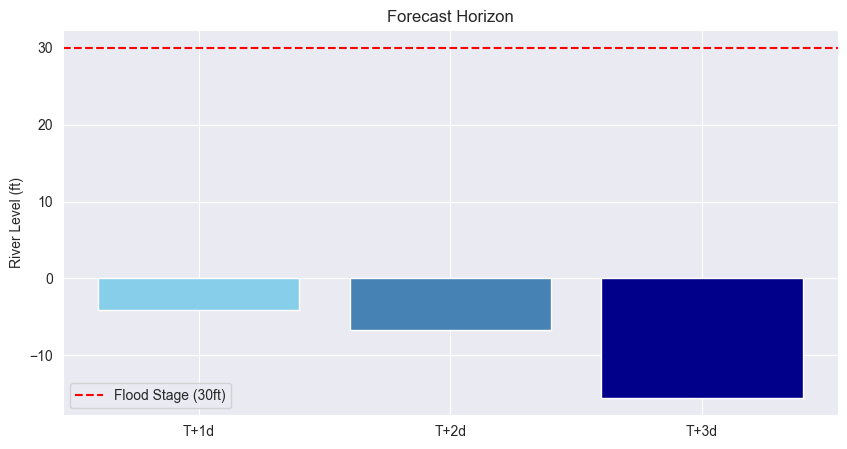

In [6]:
print("="*60)
print(f"🌊 ST. LOUIS RIVER FORECAST (Current Level: {clean_history.iloc[-1]['target_level_max']:.2f} ft)")
print("="*60)

predictions = []

for dt in LEAD_TIMES:
    if dt not in MODELS: continue

    # 1. Get components
    model = MODELS[dt]
    scaler_x, scaler_y = SCALERS[dt]
    feats = FEATURES[dt]

    # 2. Prepare & Predict
    X = prepare_features(clean_history, feats)
    X_s = scaler_x.transform(X).reshape((1, 1, len(feats)))
    pred = scaler_y.inverse_transform(model.predict(X_s, verbose=0))[0][0]

    # 3. Status
    status = "⚠️ FLOOD RISK" if pred > FLOOD_THRESHOLD else "✅ SAFE"
    color = "red" if pred > FLOOD_THRESHOLD else "green"

    print(f"T + {dt} Days:  {pred:.2f} ft  [{status}]")
    predictions.append(pred)

# Plot
plt.figure(figsize=(10, 5))
days = [f"T+{d}d" for d in LEAD_TIMES if d in MODELS]
plt.bar(days, predictions, color=['skyblue', 'steelblue', 'darkblue'])
plt.axhline(FLOOD_THRESHOLD, color='red', linestyle='--', label='Flood Stage (30ft)')
plt.ylabel("River Level (ft)")
plt.title("Forecast Horizon")
plt.legend()
plt.show()
